# Week 12: U-Net
## Convolutional Networks for Image Segmentation

Olaf Ronneberger, Philipp Fischer, and Thomas Brox
2015

U-Net is a segmentation network whose architecture resembles the letter "u". The network "contracts to capture context and a symmetric expanding path that enables precise localization" (Ronnenberger et al. 2015).

![unet.PNG](unet.PNG)

The example provided here will use a dataset of images we chose to use is labeled to classify cars. There are two labels in these images ('car' and 'not car'). 


## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overall accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:

$$\Large
w(x) = w_c(x) + w_0\ \cdot\ exp\ (-\ \frac{(d_1(x) + d_2(x))^2}{2 \sigma^2})
$$

$$\small  
x\ is\ the\ current\ pixel \\  
w_c\ is\ the\ class\ weighting\ that\ upweights\ classes\ differently \\  
d_1\ is\ the\ distance\ to\ the\ nearest\ cell\ boundary \\  
d_2\ is\ the\ distance\ to\ the\ second\ nearest\ cell\ boundary \\  
w_0\ and\ \sigma\ are\ constants\ that\ scale\ the\ weighting $$  
  
### Example:  
Let's implement this in code. First we need to develop a function that can generate random cells to simulate a microscopy image:


In [2]:
# from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import os

def generate_random_circles(n = 50, d = 100, cell_size = 20):

  """
  Generate a numpy array that is a simulated mask for an image of 
  cells where the in-cell pixels are 1 and background pixels are 0. 
  Used as prelimiary generator for unet_weight_map function.

  Parameters
  ----------
  n:  int
      Number of cells to be created
  d:  int
      Dictionary of weight classes.
  Returns
  -------
  Numpy array
      Simulated mask for a cell-image. A 2D array of shape (d,d).
  """
  # Generate coordinates for random circles
  circles = np.random.randint(0, d, (n, 3))
  # Ensure radius (3rd col) is between d/3 and d
  circles[:,2] = np.interp(circles[:,2], (circles[:,2].max(), circles[:,2].max()), (d/3,d))

  # Generate background for simluated cell image 
  x = np.zeros((d, d), dtype=int)
  
  # Iterate over circles and insert into simulated image
  for x0, y0, r in circles:
    copy_x = deepcopy(x)
    # Generate new 2D array with circle of pixels with value 1 for current circle
    new_x = np.fromfunction(lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*cell_size)**2, x.shape)
    
    # Add new circle to cell map
    for i in range(1,len(new_x)-1):
      for j in range(1,len(new_x[0])-1):
        # Only add to cell map if neighbours are 0
        if new_x[i][j] == True and x[i-1][j]==0 and x[i-1][j-1]==0 and x[i][j-1]==0 and x[i][j+1]==0 and x[i+1][j+1]==0 and x[i+1][j]==0 and x[i+1][j-1]==0 and x[i-1][j+1]==0:
          copy_x[i][j] += new_x[i][j]
    x += copy_x
  
  # Clip values above 1 to a max of 1
  x = np.clip(x, 0, 1)

  # Return simulated cell map
  return x

/tmp/ipykernel_135975/3373085685.py:3: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


Second we need to implement the weighting function that weights each pixel in the image based on it's distance to the nearest cell boundaries:

In [3]:

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

  """
  Generate weight maps as specified in the U-Net paper
  for boolean mask.
  
  "U-Net: Convolutional Networks for Biomedical Image Segmentation"
  https://arxiv.org/pdf/1505.04597.pdf
  
  Parameters
  ----------
  mask: Numpy array
      2D array of shape (image_height, image_width) representing binary mask
      of objects.
  wc: dict
      Dictionary of weight classes.
  w0: int
      Border weight parameter.
  sigma: int
      Border width parameter.
  Returns
  -------
  Numpy array
      Training weights. A 2D array of shape (image_height, image_width).
  """
  
  # Grab labels from input
  labels = label(y)
  no_labels = labels == 0
  label_ids = sorted(np.unique(labels))[1:]

  # Check for circles in y
  if len(label_ids) > 1:
    # Calculate distances
    distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))
    for i, label_id in enumerate(label_ids):
      distances[:,:,i] = distance_transform_edt(labels != label_id)

    # Sort for nearest cell boundary distances
    distances = np.sort(distances, axis=2)
    d1 = distances[:,:,0]
    d2 = distances[:,:,1]
    
    # Calculate second term in weighting equation
    w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

    # Sum with class weights to produce weighted mask
    if wc:
      class_weights = np.zeros_like(y)
      for k, v in wc.items():
        class_weights[y == k] = v
      w = w + class_weights
  
  # If no circles we passed in to the function, return zeros
  else:
    w = np.zeros_like(y)
  
  # Return weighted mask
  return w


Let's generate a simulated cell image mask and then weight the pixels of that mask. You need to choose weighting values for the two classes, cell and non-cell:

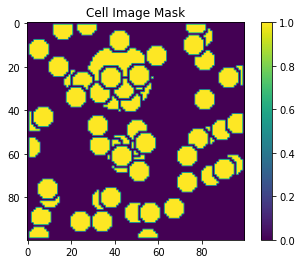

Class Weighting: {0: 100, 1: 1}


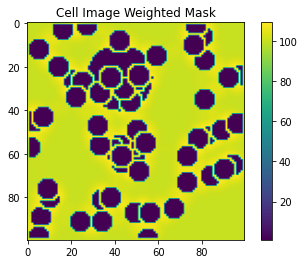

In [7]:
# Generate simulated cell mask 
num_cells        = 60
image_dimensions = 100
cell_size        = 15
y = generate_random_circles(num_cells, image_dimensions, cell_size)

# Display cell mask
plt.imshow(y)
plt.title('Cell Image Mask')
plt.colorbar()
plt.show()

# Weighting for pixels assigned to the two classes
class_weighting = {
  # TODO: Choose weighting values for the classes in the cell mask - they are currently set to 0.
  0: 100, # background
  1: 1  # cells
}

print('Class Weighting:', class_weighting)

# Generate weighted map
w = unet_weight_map(y, class_weighting)

# Display weighted mask
plt.imshow(w)
plt.title('Cell Image Weighted Mask')
plt.colorbar()
plt.show()

**TO DO: Try adjusting the weighting of the class in the class_weighting dictionary (or other parameters) and see what impact that has on the final weighted mask.**

*Increasing the cell class weight makes the weighted mask really blurry. If the two weights are equal, the weighted mask labels the empty space as cell. With the background weight increased, we see a much cleaner picture differentiating cells from background.*


# Implementing U-Net

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms as TF

We use the double convolution quite a lot in this architecture so let's implement it as a reusable code block.

In [9]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),  # 3x3 convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


Now let's devise the network using Pytorch functionality.

In [10]:

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

For a sanity check, let's just make sure that we are getting a prediction that is the shape we would expect.

**QUESTION: Given the shape of the torch.randn() and the fact that we're using padding, what do you expect the output shape to be?**

*Since we're using padding, the output shape should be the same size as the input shape. If we didn't use padding, then the output shape would be smaller by some amount depending on the size of the kernel.*

In [11]:
x = torch.randn((3, 1, 50, 50))
model = UNET(in_channels=1, out_channels=1)
preds = model(x)
assert preds.shape == x.shape


### Dataset Loader
Now we'll prepare our data for training and testing using Pytorch's DataLoader which will pass in samples in “minibatches”.

In [12]:
from PIL import Image
from torch.utils.data import Dataset

class CarDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

### Useful Utility Functions
Some of the operations we perform can be functionalized to save on repetition. The two examples below are getting the data loaders and validating the model.

In [13]:
from torch.utils.data import DataLoader

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
):
    train_ds = CarDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
    )

    val_ds = CarDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader

def validation_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x
            y = y.unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
    print(f"Got {num_correct}/{num_pixels} pixels with acc {num_correct/num_pixels*100:.2f}")
    model.train()

### Training Function

In [14]:
def train_fn(loader, model, optimizer, loss_fn):

    for batch_idx, (data, targets) in enumerate(loader):

        # forward
        predictions = model(data)
        loss = loss_fn(predictions, targets.float().unsqueeze(1))

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Iter: {batch_idx+1}/{len(loader.dataset)}, Loss: {loss.item():.04f}")


### Hyperparameters
Choose hyperparameters for the model. Experiment with the learning rate and batch size.

In [16]:
# Hyperparameters

# TODO: experiment with different values
LEARNING_RATE = 1e-4
BATCH_SIZE = 10

IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
LOAD_MODEL = False

cwd = os.getcwd()

TRAIN_IMG_DIR = os.path.join(cwd, "data", "train_images")
TRAIN_MASK_DIR = os.path.join(cwd, "data", "train_masks")
VAL_IMG_DIR = os.path.join(cwd, "data", "val_images")
VAL_MASK_DIR = os.path.join(cwd, "data", "val_masks")

### Data Transformation
The images in this dataset are quite large, so we will need to reduce the size in order to make the training time a little more reasonable. While this might sacrifice some accuracy due to compression, we can run more data through the model during training this way.

In [18]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[1.0, 1.0, 1.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)


### Training the Model

**Question: Why do we use the BCEWithLogitsLoss function for training the model?**  
The documentation is [here](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).

*This loss function combines the sigmoid and the BCE into one step. Since our target data will be a vector of 1 for "car" and 0 for "no car", this will allow us to get the sigmoid predictions for each pixel and compute the loss in one step.*

**Question: Given the authors of the original U-Net paper chose SGD, is Adam the best optimizer for this implementation?**  
Consider trying [a couple of different ones](https://pytorch.org/docs/stable/optim.html#algorithms) and see what happens.

*Using the Adam optimizer allows the model to train much faster. Presumably this is because it helps to smoothe out the gradient and converge more directly.*


In [34]:
model = UNET(in_channels=3, out_channels=1)

loss_fn = nn.BCEWithLogitsLoss()

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)

train_fn(train_loader, model, optimizer, loss_fn)


Iter: 1/224, Loss: 0.7224
Iter: 2/224, Loss: 0.6491
Iter: 3/224, Loss: 0.6176
Iter: 4/224, Loss: 0.5824
Iter: 5/224, Loss: 0.5617
Iter: 6/224, Loss: 0.5142
Iter: 7/224, Loss: 0.5081
Iter: 8/224, Loss: 0.4734
Iter: 9/224, Loss: 0.4540
Iter: 10/224, Loss: 0.4636
Iter: 11/224, Loss: 0.4279
Iter: 12/224, Loss: 0.4025
Iter: 13/224, Loss: 0.3848
Iter: 14/224, Loss: 0.3982
Iter: 15/224, Loss: 0.3596
Iter: 16/224, Loss: 0.3598
Iter: 17/224, Loss: 0.3495
Iter: 18/224, Loss: 0.3505
Iter: 19/224, Loss: 0.3510
Iter: 20/224, Loss: 0.3328
Iter: 21/224, Loss: 0.3351
Iter: 22/224, Loss: 0.3330
Iter: 23/224, Loss: 0.3265


### Validating the Model

In [36]:
validation_accuracy(val_loader, model)

Got 1900326/2457600 pixels with acc 77.32


Let's visualise a couple randomly selected validation predictions and see how well the model did.

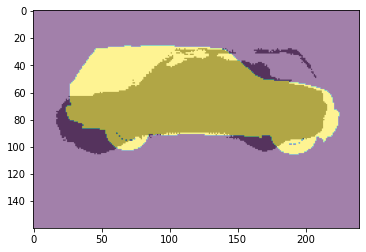

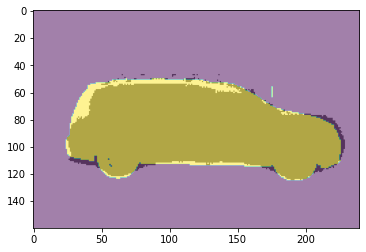

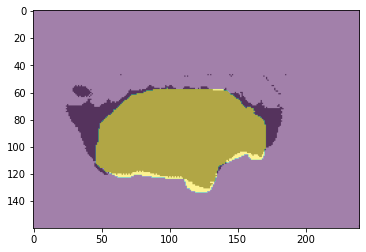

In [37]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()
  

**Question: What you do notice about the predicted mask that is less than optimal?**  

*It seems to have a harder time when the car is at an angle, and sometimes it creates a mask that's pointed in the opposite direction of the actual image.*

### Data Augmentation
Let's train the model on some new data (in a sense). We can augment the data that we feed to the model by performing horizontal flips on the images of the cars, or even changing the distribution of the normalized values. 

In [38]:
train_transform = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

val_transforms = A.Compose(
  [
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
      mean=[0.0, 0.0, 0.0],
      std=[2.0, 2.0, 2.0],
      max_pixel_value=255.0,
    ),
    ToTensorV2(),
  ],
)

train_loader, val_loader = get_loaders(
  TRAIN_IMG_DIR,
  TRAIN_MASK_DIR,
  VAL_IMG_DIR,
  VAL_MASK_DIR,
  BATCH_SIZE,
  train_transform,
  val_transforms,
)


Now continue training the model:

In [39]:
train_fn(train_loader, model, optimizer, loss_fn)

Iter: 1/224, Loss: 0.3164
Iter: 2/224, Loss: 0.3151
Iter: 3/224, Loss: 0.3123
Iter: 4/224, Loss: 0.3083
Iter: 5/224, Loss: 0.3043
Iter: 6/224, Loss: 0.2931
Iter: 7/224, Loss: 0.3104
Iter: 8/224, Loss: 0.2964
Iter: 9/224, Loss: 0.2956
Iter: 10/224, Loss: 0.2888
Iter: 11/224, Loss: 0.2943
Iter: 12/224, Loss: 0.2927
Iter: 13/224, Loss: 0.2822
Iter: 14/224, Loss: 0.2821
Iter: 15/224, Loss: 0.2903
Iter: 16/224, Loss: 0.2856
Iter: 17/224, Loss: 0.2816
Iter: 18/224, Loss: 0.2779
Iter: 19/224, Loss: 0.2708
Iter: 20/224, Loss: 0.2932
Iter: 21/224, Loss: 0.2700
Iter: 22/224, Loss: 0.2745
Iter: 23/224, Loss: 0.2867


Take a look at some of the model predictions.  
  
**Question: How has the model performance changed and why?**  

*The masks much more closely match the images in all orientations. This is expected since the model has been exposed to more diverse orientations of cars after augmentation. However, I think it's questionable whether the improvement is actually because of the augmentation or just because it trained longer and saw more data. It would be interesting to know what portion of the original dataset had the cars rotated in different orientations--presumably more data would have improved performance in the same way as long as the training and validation data had a similar distribution of car orientations in it.*

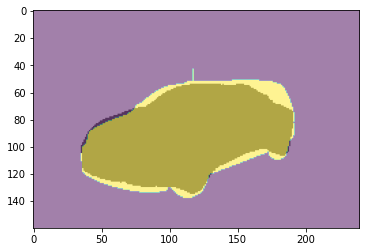

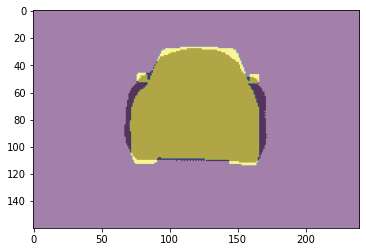

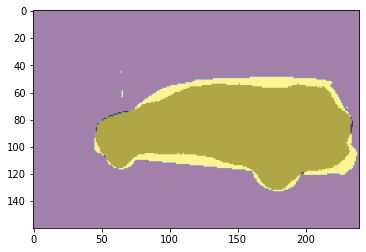

In [41]:
# TODO: how many predictions do you want to visualize?
num_predictions = 3

for i in range(num_predictions):
  # select a random image
  idx = np.random.randint(0, len(val_loader.dataset))
  # Get a prediction with that image
  pred = torch.sigmoid(model(val_loader.dataset[idx][0].unsqueeze(0)))
  pred = (pred > 0.5).float()
  # display the prediction overlaid with the target mask
  plt.imshow(pred.squeeze(), cmap="Greys", alpha=0.6)
  plt.imshow(TF.ToPILImage()(val_loader.dataset[idx][1]).convert('L'), alpha=0.5)
  plt.show()


**As an optional final task, try training a new model on variations of augmented data and see how the performance changes with different augmentations.** 